In [1]:
import os
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# cwd
print(f'Current working directory: {os.getcwd()}')
# change directory
os.chdir('../')
print(f'New working directory: {os.getcwd()}')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Current working directory: /Users/gbemidebe/Documents/GitHub/ImputeNet/notebooks
New working directory: /Users/gbemidebe/Documents/GitHub/ImputeNet


# 1. Load Data

SA --> surface area 
DG --> defect ratio
%N --> percent nitrogen
%O --> percent oxygen
%S --> percent sulphur
CD --> current density
CONC --> concentration of electrolyte
CAP --> specific capacitance

In [2]:
import pandas as pd

desired_columns = ['SA', 'DG', '%N', '%O', '%S', 'CD', 'CONC', 'CAP']

data = pd.read_csv('data/specific_capacitance_data.csv')
data = data[desired_columns]
print(data.shape)
data.head()

(620, 8)


,SA,DG,%N,%O,%S,CD,CONC,CAP
0,1122.5,0.85,NaN,5.7,NaN,0.5,6.0,240.63
1,1122.5,0.85,NaN,5.7,NaN,1.0,6.0,228.13
2,1122.5,0.85,NaN,5.7,NaN,2.0,6.0,225.00
3,1122.5,0.85,NaN,5.7,NaN,5.0,6.0,215.63
4,1122.5,0.85,NaN,5.7,NaN,10.0,6.0,206.25


In [3]:
# drop missing values
clean_data = data.dropna()
print(clean_data.shape)
clean_data.head()

(159, 8)


,SA,DG,%N,%O,%S,CD,CONC,CAP
152,308.8,1.01,1.46,11.94,1.14,0.5,6.0,378.0
153,308.8,1.01,1.46,11.94,1.14,1.0,6.0,352.0
154,308.8,1.01,1.46,11.94,1.14,2.0,6.0,325.0
155,308.8,1.01,1.46,11.94,1.14,5.0,6.0,308.0
156,308.8,1.01,1.46,11.94,1.14,10.0,6.0,292.0


# 2. Load trained Model

In [4]:
# Import Libraries
import tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from datetime import datetime
from keras import backend as K
# https://github.com/keras-team/keras/issues/7947

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))


In [5]:
# Function to create model, required for KerasRegressor
def build_model():
    # {'num_layers': 10, 'units_0': 21, 'units_1': 38, 'units_2': 9, 'units_3': 35, 'units_4': 21,
    # 'units_5': 45,'units_6': 50, 'units_7': 14, 'units_8': 50, 'units_9': 10, 'learning_rate': 0.01,}
    model = Sequential()
    model.add(Dense(21, input_dim=7, activation='relu'))
    model.add(Dense(38, activation='relu'))
    model.add(Dense(9, activation='relu'))
    model.add(Dense(35, activation='relu'))
    model.add(Dense(21, activation='relu'))
    model.add(Dense(45, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(14, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(keras.layers.Dense(1, activation='linear'))


    model.compile(optimizer=tensorflow.keras.optimizers.legacy.Adam(learning_rate=0.01),
                          loss="mean_squared_error", 
                          metrics=["mean_squared_error", rmse, r_square])
    
    return model


In [6]:
# Create a new model for transfer learning
reloaded_TargetModel = build_model()
# Restore the weights
reloaded_TargetModel.load_weights('./models/specific_capacitance_target_model_ETR_imputation_approach.h5')
reloaded_TargetModel.get_weights()

[array([[-0.20077813,  0.8350732 ,  0.7231782 , -0.23601975, -0.07467222,
          0.43934092,  0.20523462, -0.15256754, -0.7161128 ,  0.28352514,
         -0.3529283 , -0.19069862, -1.5971189 , -1.2791731 , -0.2813979 ,
         -0.07092988, -0.06268024,  1.0283135 , -0.24857229,  1.2012216 ,
         -0.73447454],
        [ 1.4428788 , -0.13848816,  0.37310895, -0.54613334, -0.3847814 ,
         -0.48956025, -0.47381696,  0.5570575 , -0.17035139, -0.63503367,
          0.01308822,  0.1797487 ,  0.57102054, -1.196856  ,  0.03482786,
          1.4042886 , -0.4524534 , -0.6797425 , -0.02529435, -0.33289906,
          0.46815297],
        [-0.18881309,  0.7883478 , -1.6548938 , -0.48061833, -0.37875152,
         -0.00922541, -1.7637225 ,  1.2287381 , -0.52045465,  0.6782233 ,
          0.47552058, -0.5237494 ,  0.48737392,  1.1301984 , -0.18813226,
         -0.05076721, -0.16052687,  0.7209138 , -0.33722067,  0.19757801,
         -0.0932346 ],
        [-0.58497685, -0.5736477 , -0.60245

In [7]:
reloaded_TargetModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 21)                168       
                                                                 
 dense_1 (Dense)             (None, 38)                836       
                                                                 
 dense_2 (Dense)             (None, 9)                 351       
                                                                 
 dense_3 (Dense)             (None, 35)                350       
                                                                 
 dense_4 (Dense)             (None, 21)                756       
                                                                 
 dense_5 (Dense)             (None, 45)                990       
                                                                 
 dense_6 (Dense)             (None, 50)                2

In [8]:
# load scaler
import pickle
scaler_name =  '2024-02-04_actual_specific_capacitance_scaler_seed612_train_size70.0percent'
scaler = pickle.load(open(f'./models/{scaler_name}.pkl', 'rb'))

In [9]:
X = clean_data.drop('CAP', axis=1)
X_train_test_val =  scaler.transform(X)

# SHAP

In [10]:
from cdi.plotters import disp_shap_bar, disp_depedency_plot, disp_shap_beeswarm

In [11]:
# merge data
explainer = shap.DeepExplainer(reloaded_TargetModel, X_train_test_val)
shap_values = explainer.shap_values(X_train_test_val)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [12]:
desired_columns

['SA', 'DG', '%N', '%O', '%S', 'CD', 'CONC', 'CAP']

In [13]:
cols = [
    r'$\rm SSA$',
    r'$\rm DG$',
    r'$\rm \%N$',
    r'$\rm \%O$',
    r'$\rm \%S$',
    r'$\rm CD$',
    r'$\rm CONC$']
    
evaluated_data = pd.DataFrame(X_train_test_val, columns=cols)

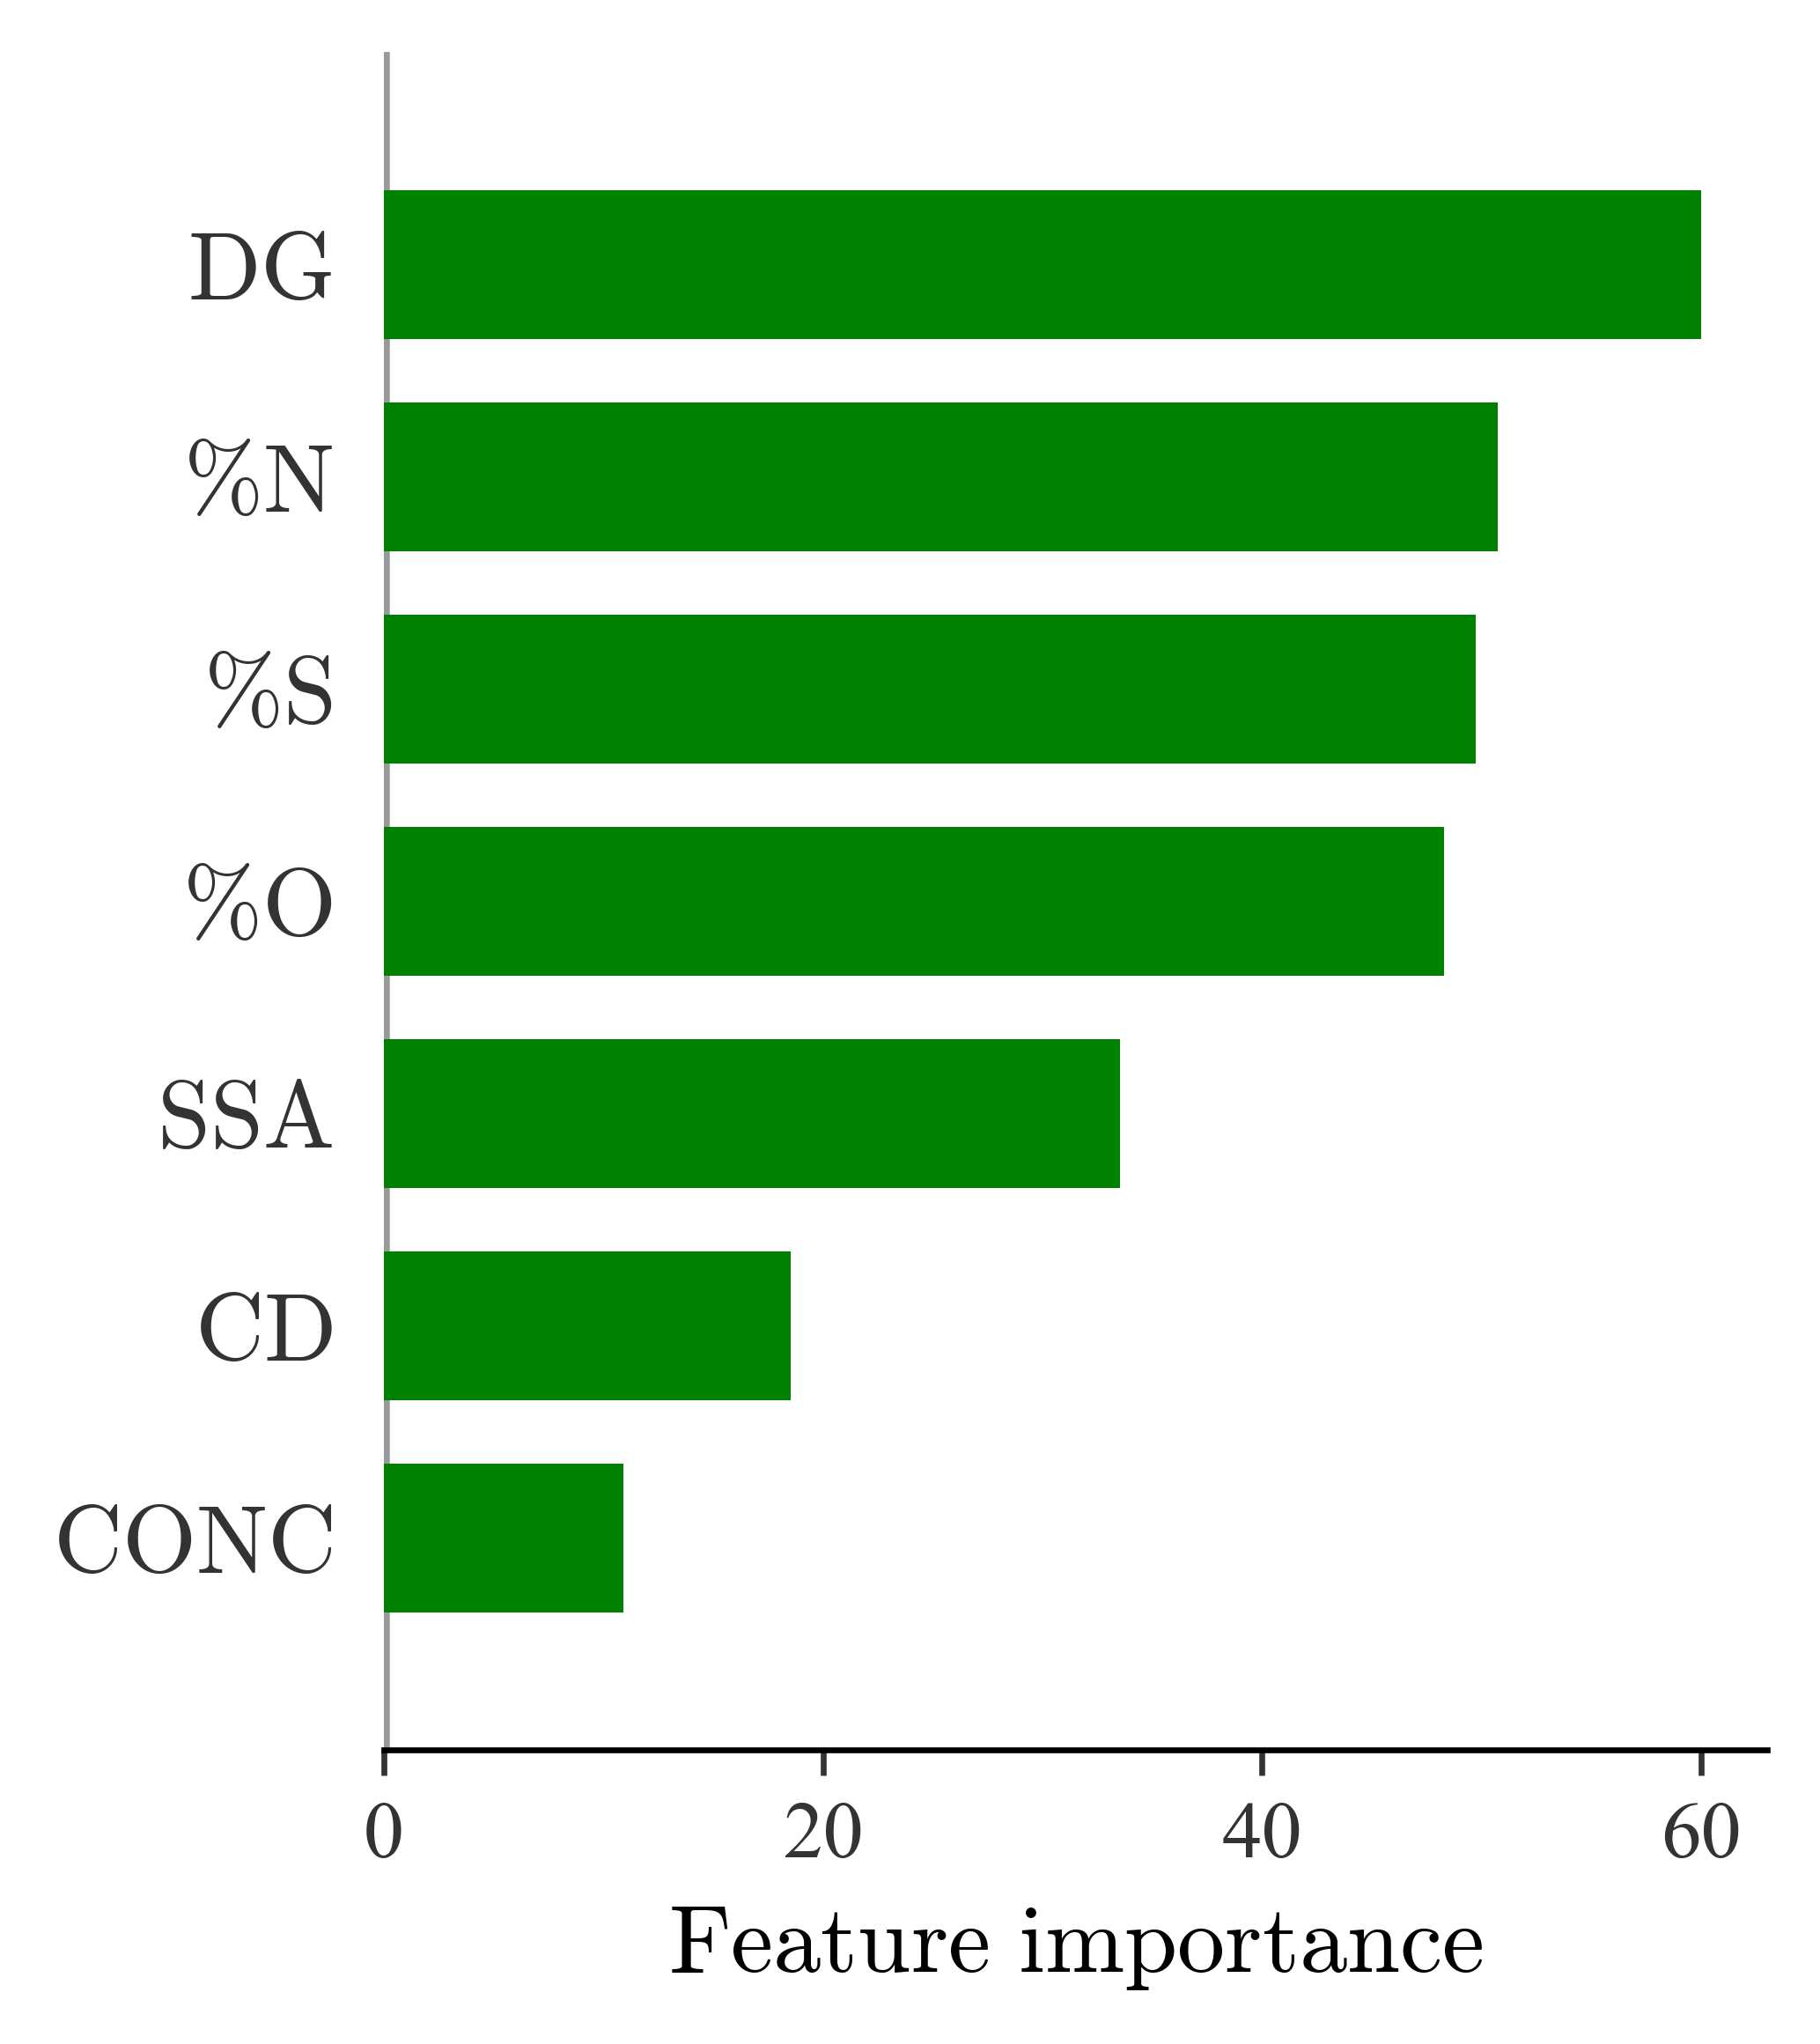

In [18]:
# plot the SHAP values in bee swarm plot
disp_shap_bar(
    shap_values = shap_values[0], 
            data = evaluated_data, 
            title = '', 
            color = 'green', 
            figsize=(3, 4))

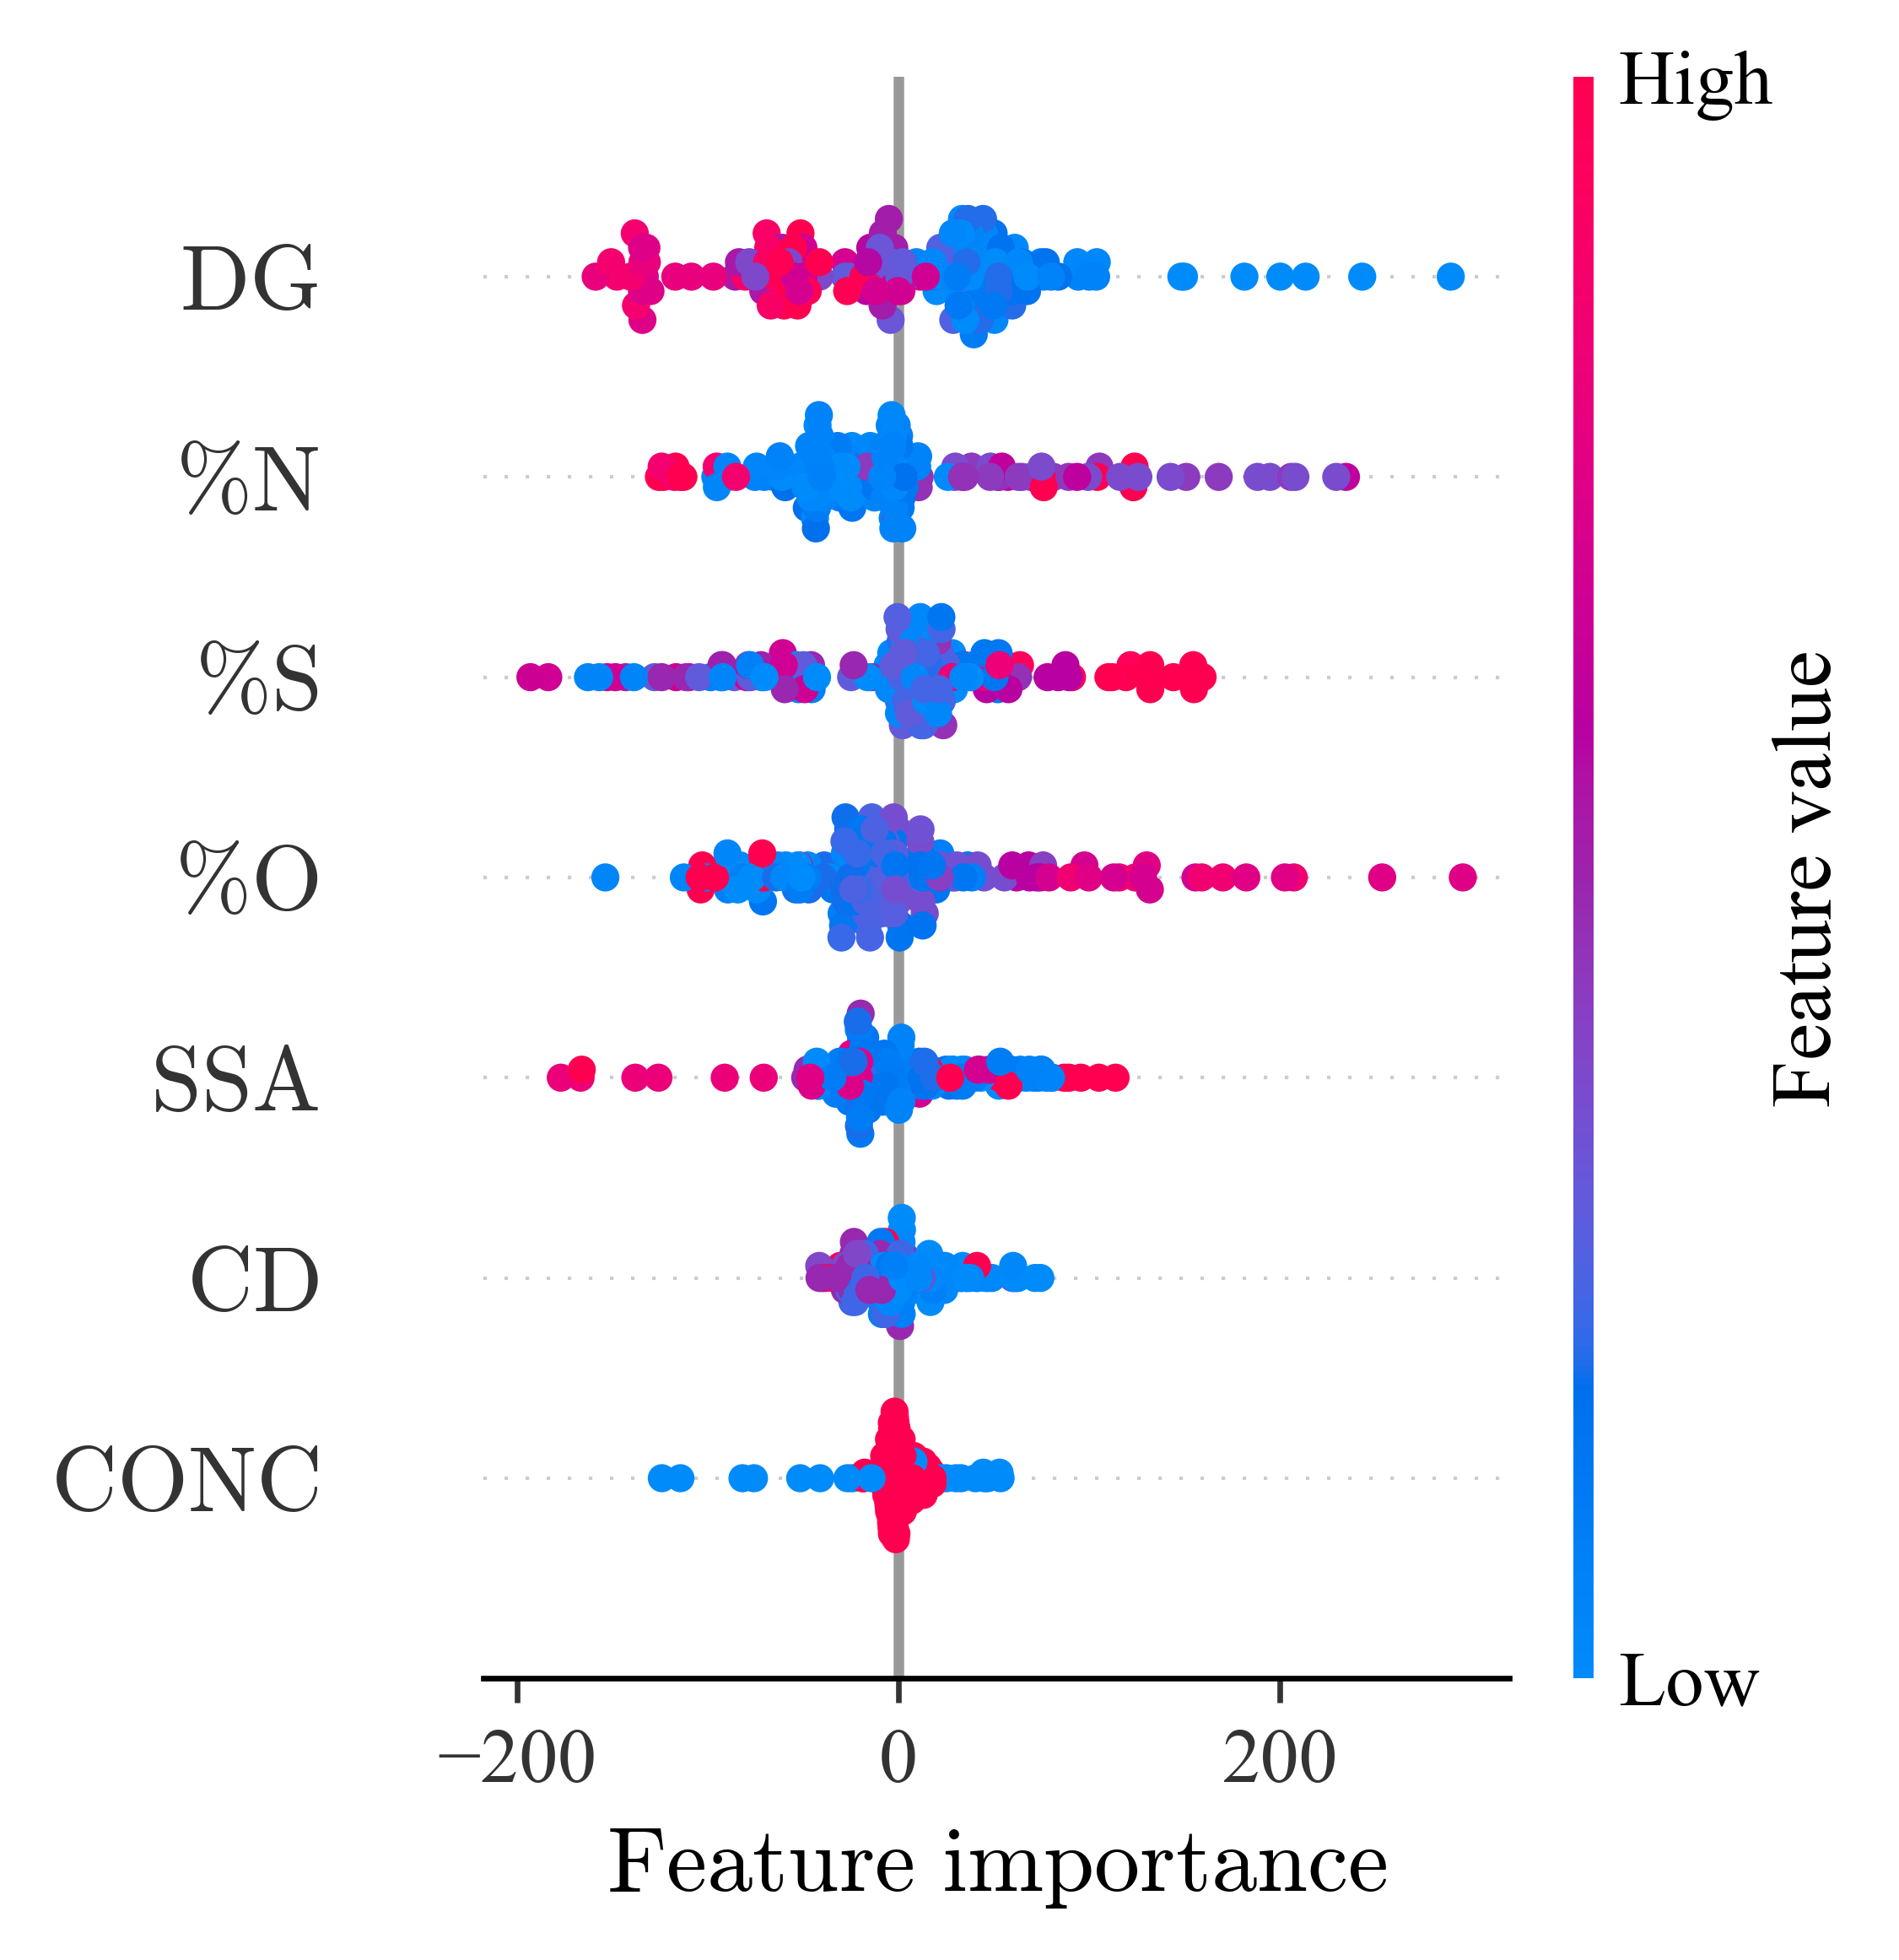

In [15]:
disp_shap_beeswarm(
    shap_values = shap_values[0], 
            data = evaluated_data, 
            title = '', 
            figsize=(3, 4))

In [16]:
cols

['$\\rm SSA$',
 '$\\rm DG$',
 '$\\rm \\%N$',
 '$\\rm \\%O$',
 '$\\rm \\%S$',
 '$\\rm CD$',
 '$\\rm CONC$']

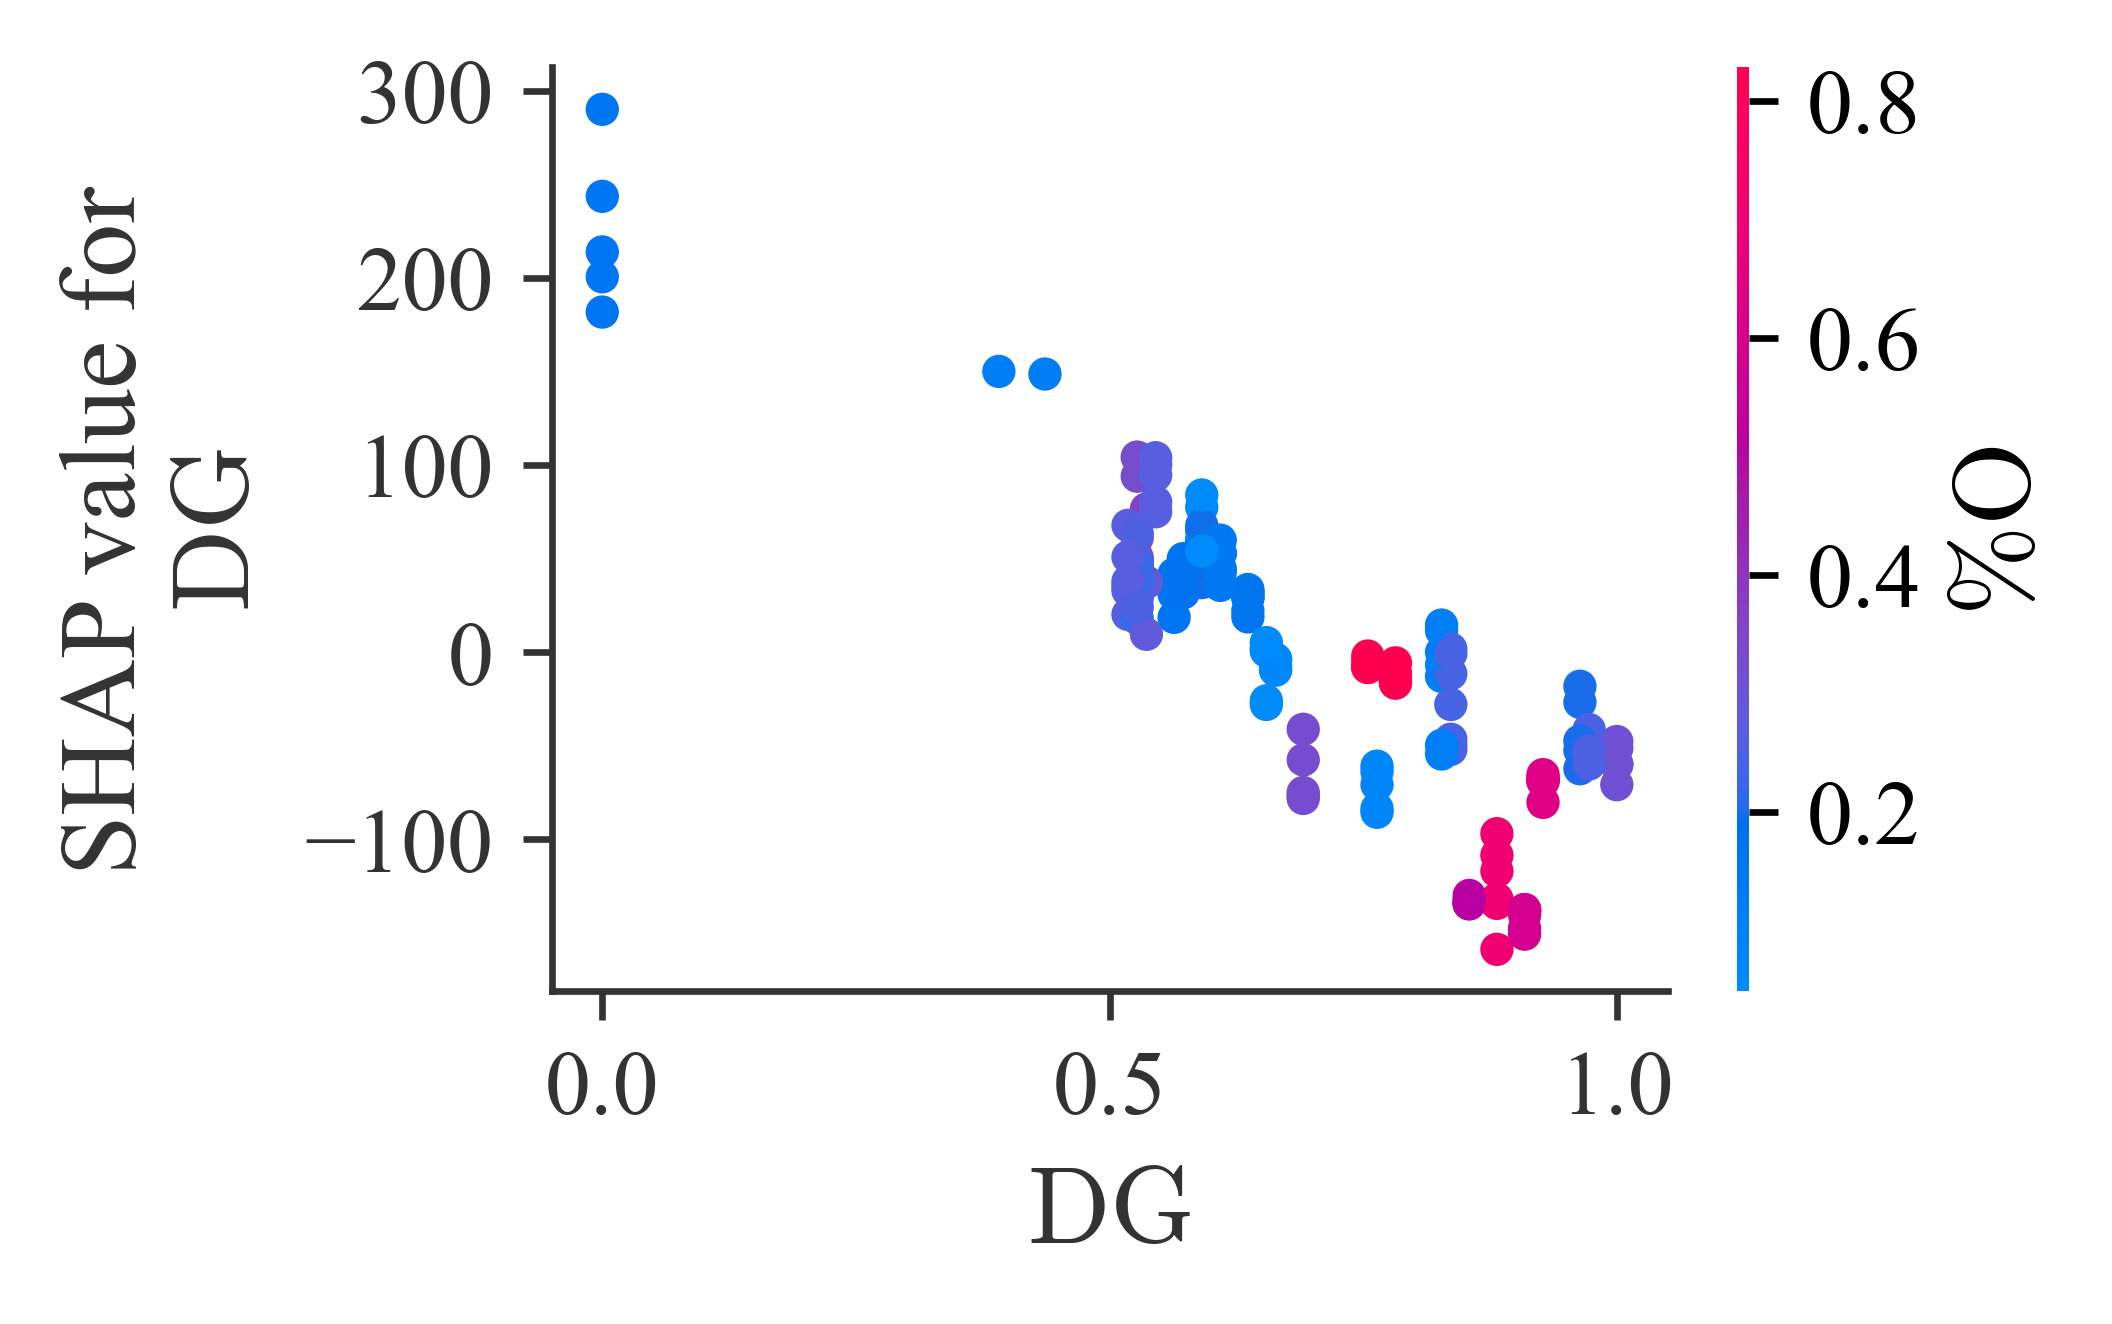

In [42]:
disp_depedency_plot(shap_values=shap_values[0], X=X_train_test_val, columns=cols, idx=1, figsize=(3, 2))

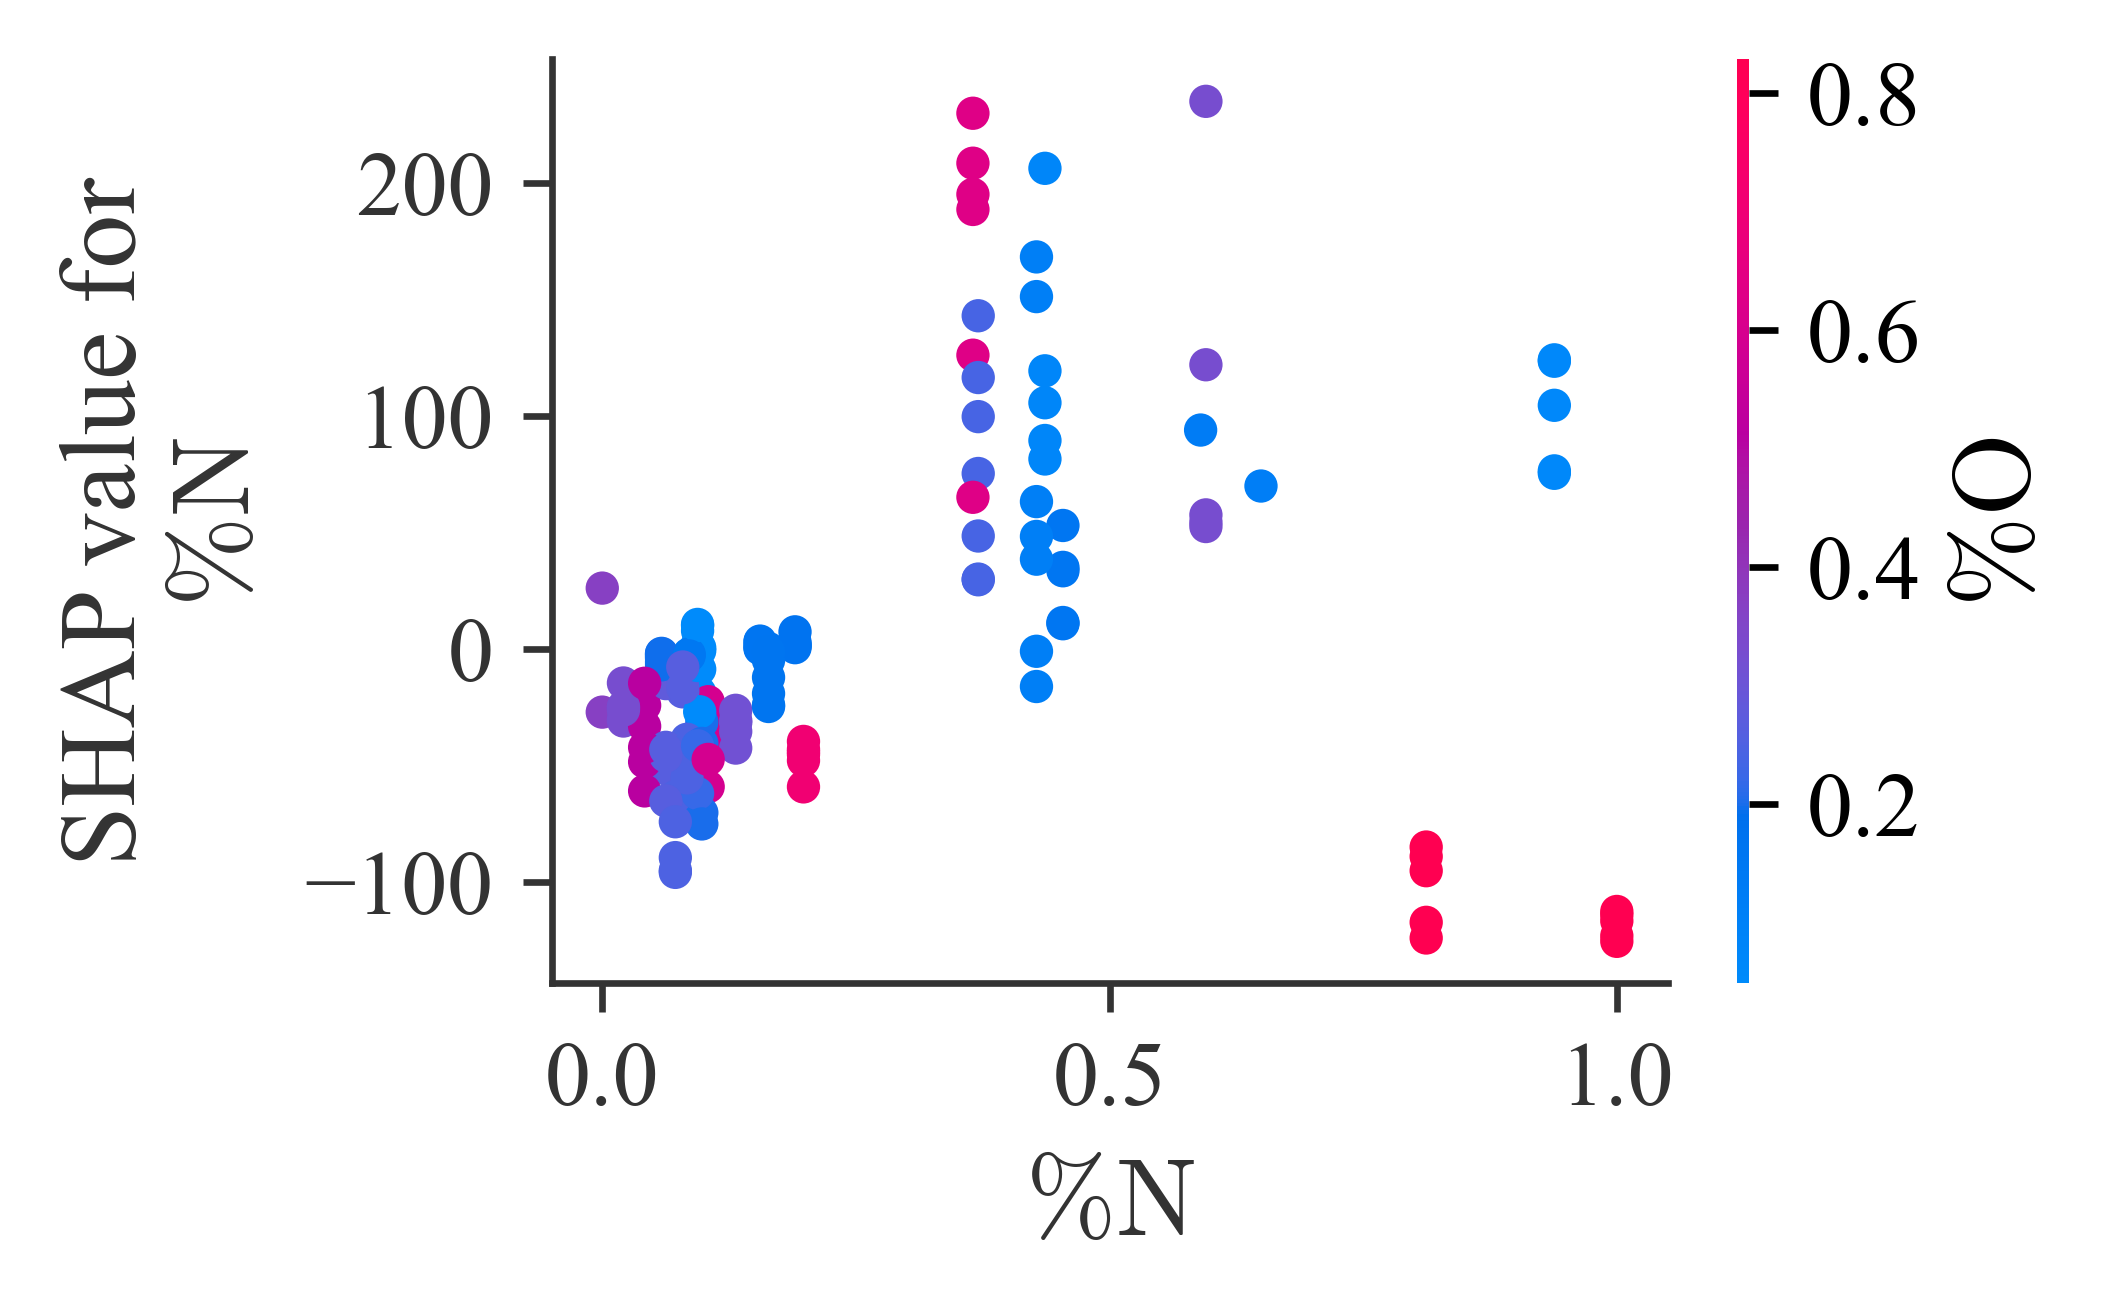

In [20]:
disp_depedency_plot(shap_values=shap_values[0], X=X_train_test_val, columns=cols, idx=2, figsize=(3, 2))

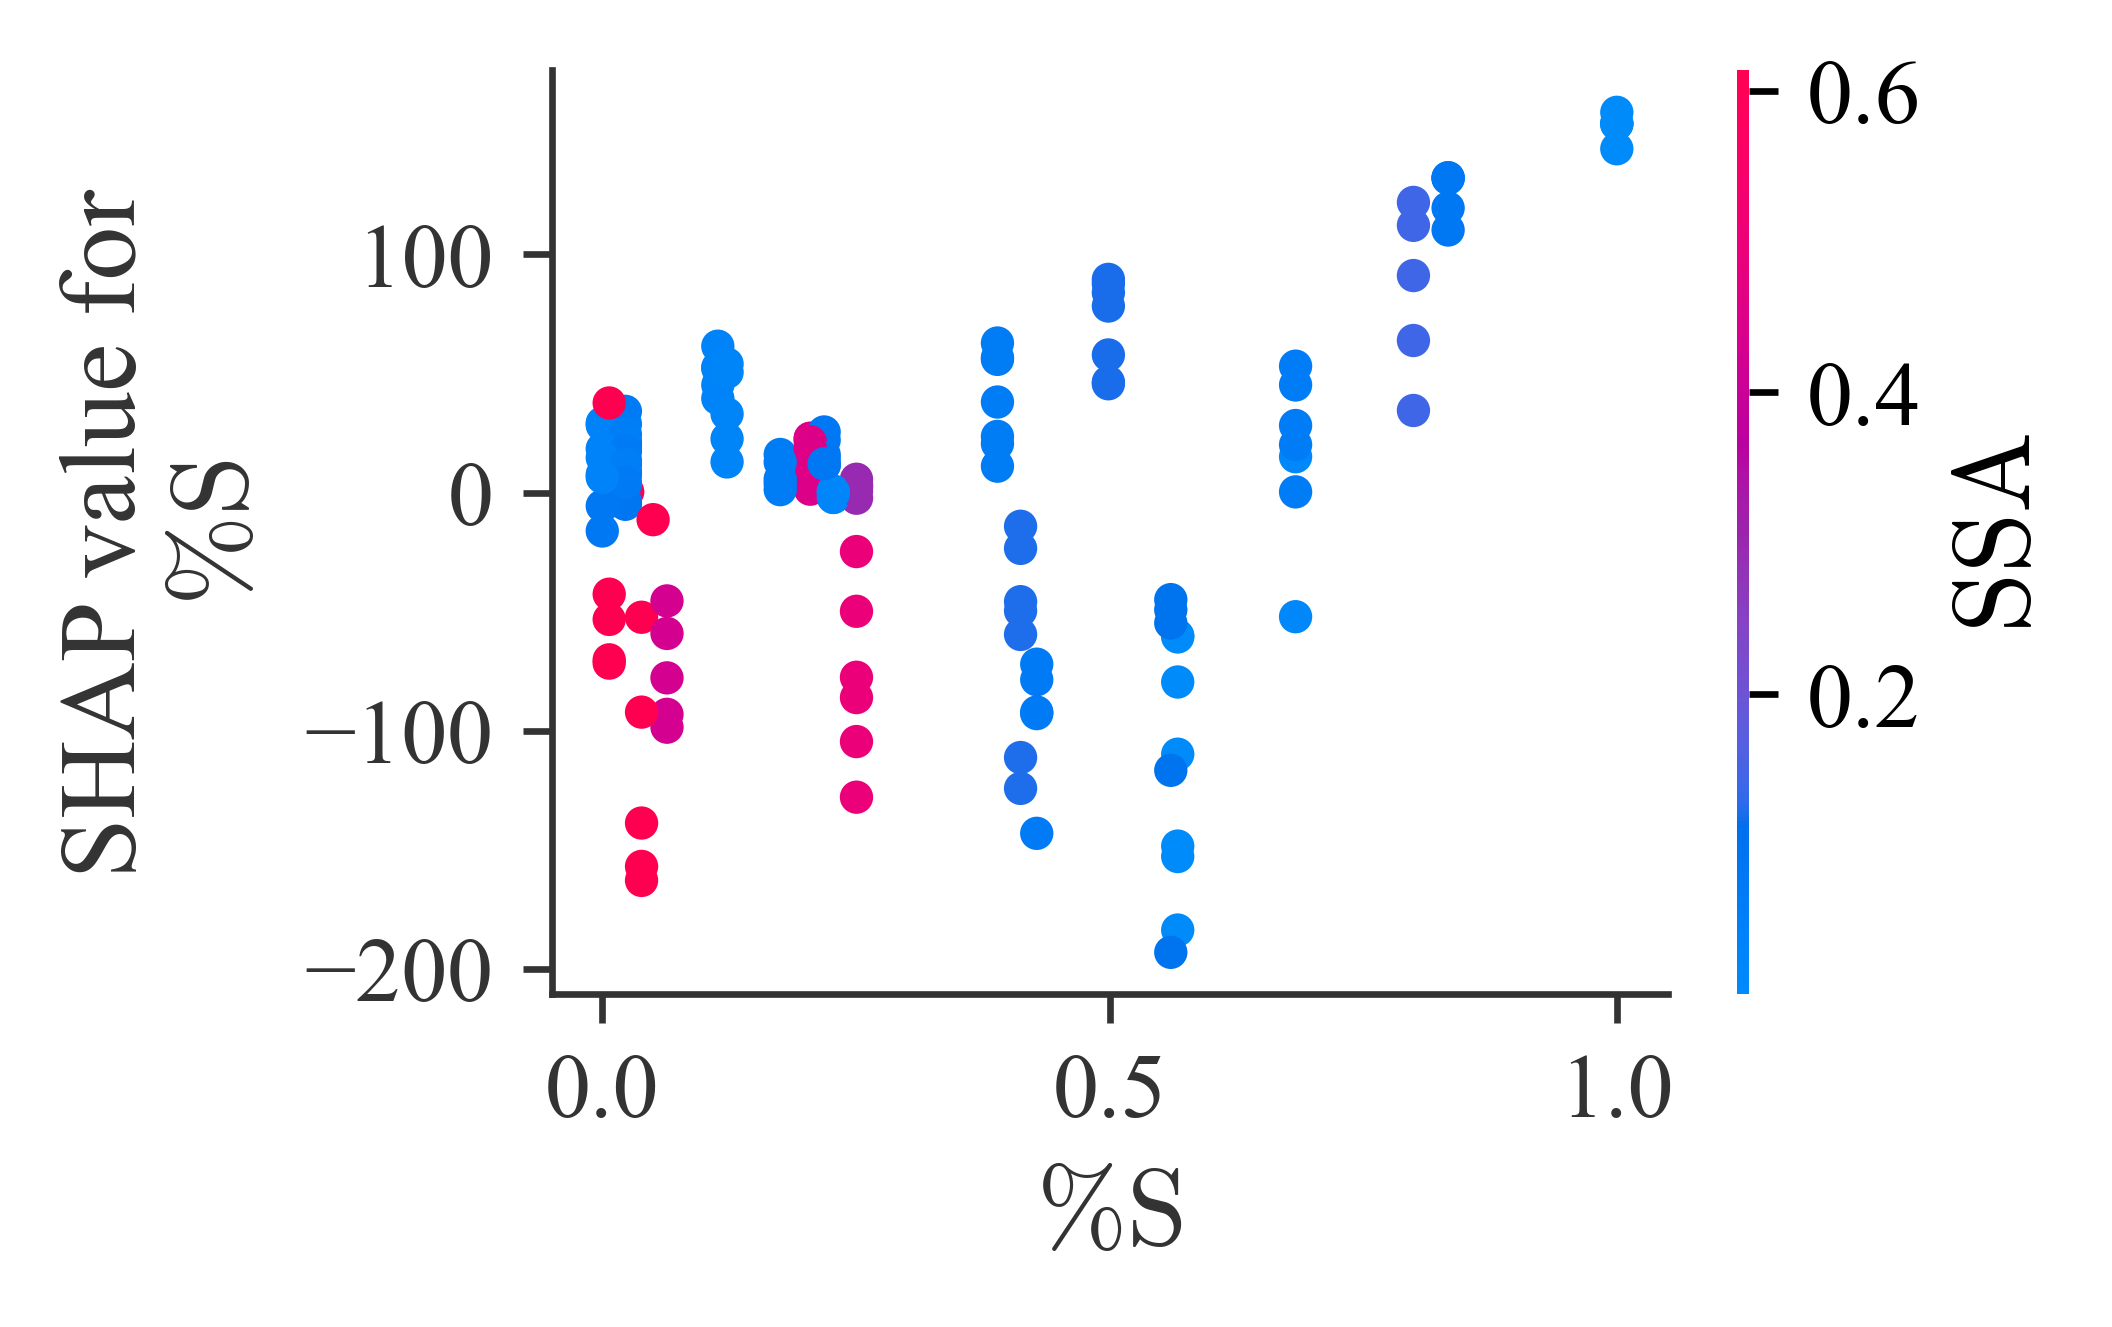

In [21]:
disp_depedency_plot(shap_values=shap_values[0], X=X_train_test_val, columns=cols, idx=4, figsize=(3, 2))

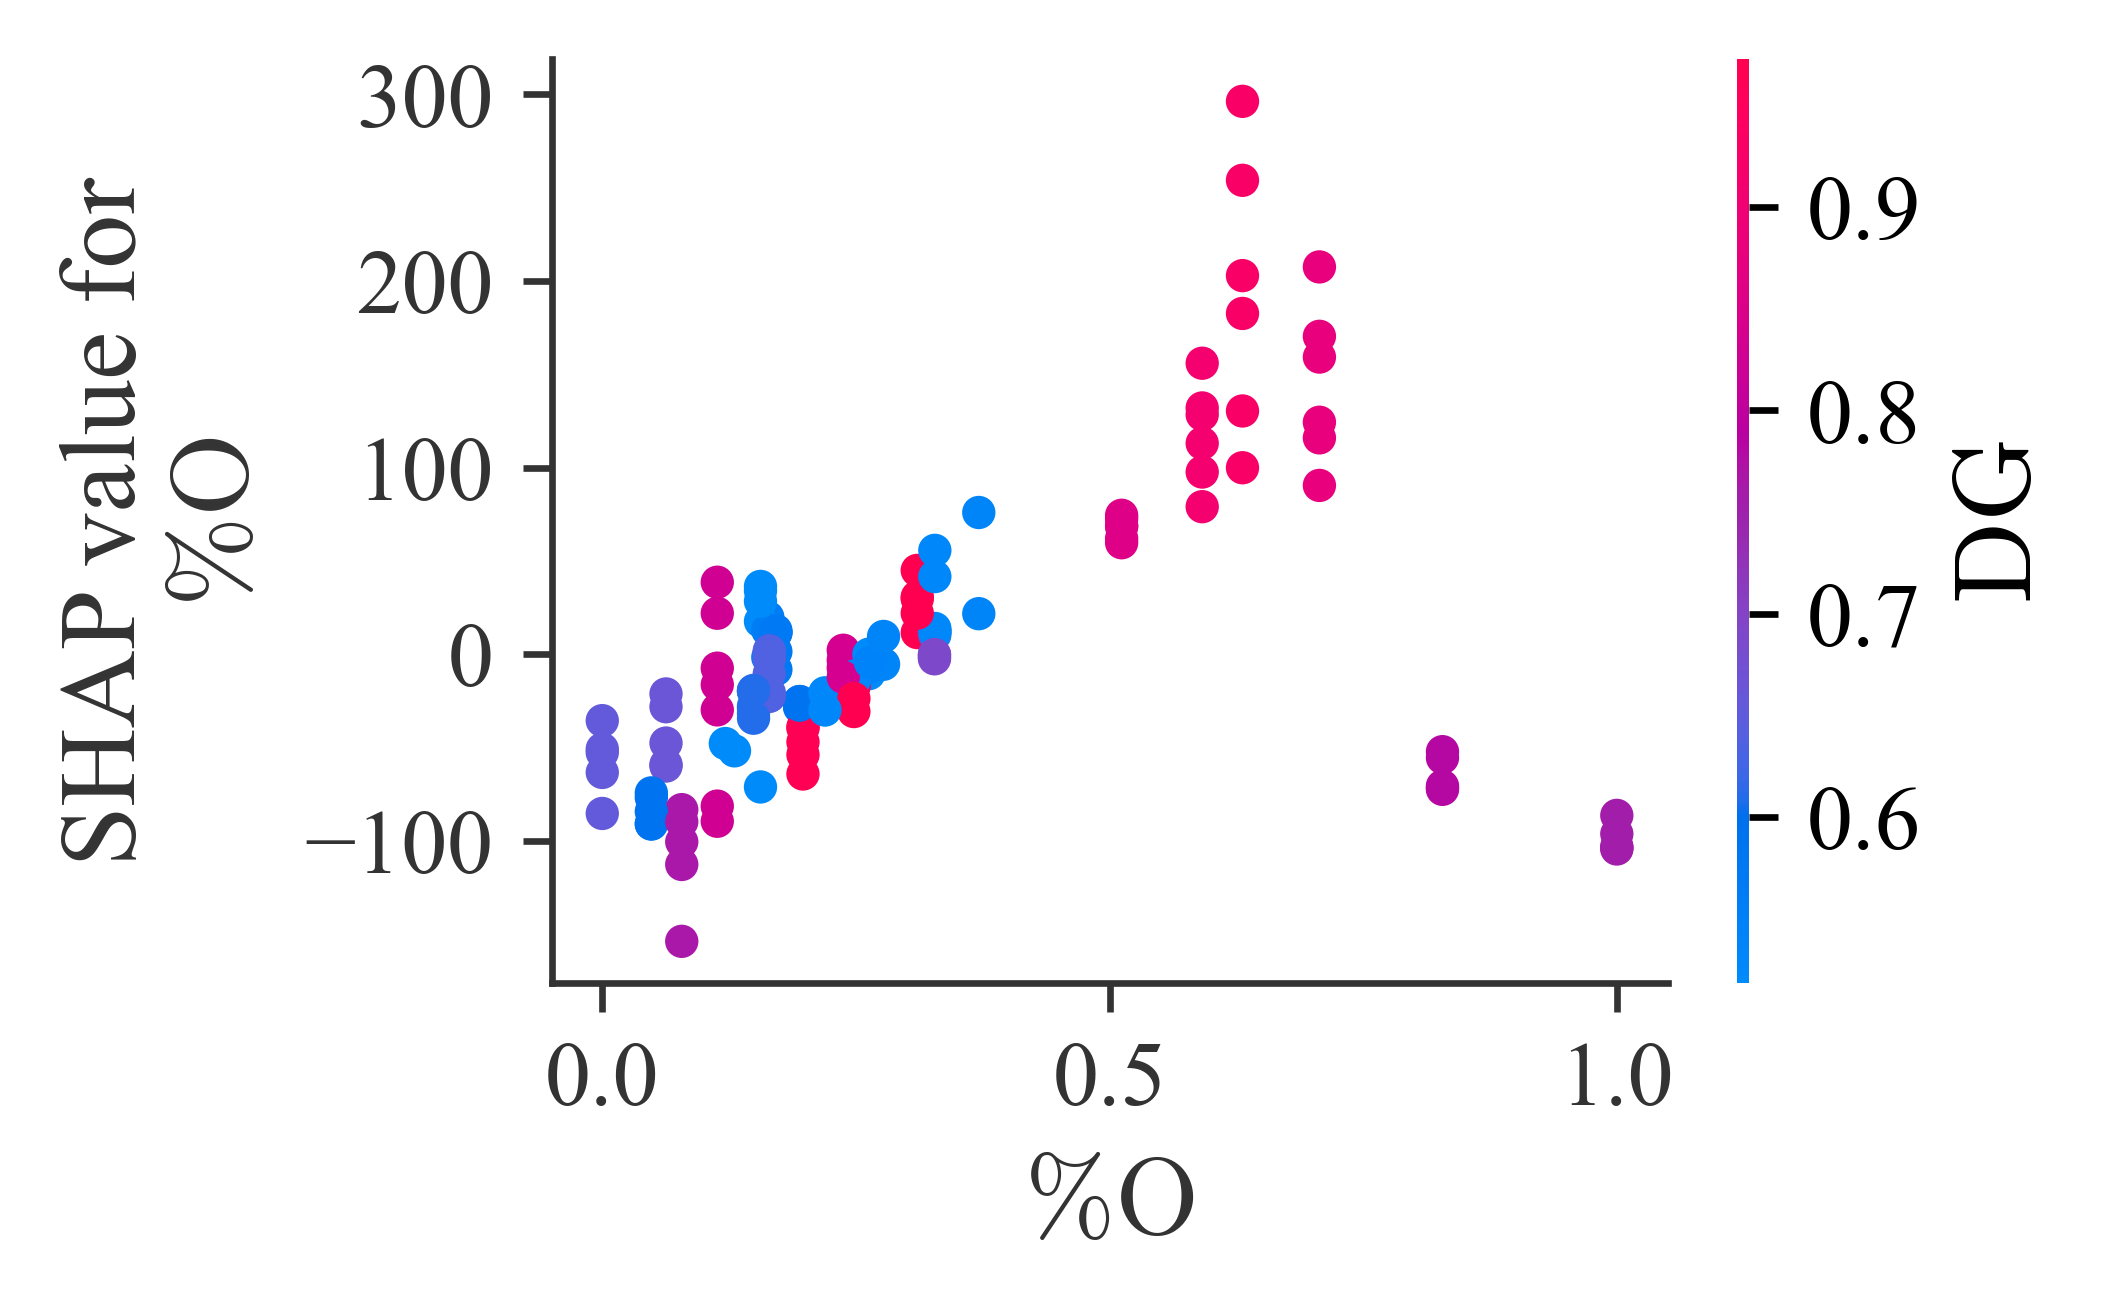

In [22]:
disp_depedency_plot(shap_values=shap_values[0], X=X_train_test_val, columns=cols, idx=3, figsize=(3, 2))